# STL-10, ResNet-18 classification with fine-tuning

The STL-10 dataset is an image recognition dataset for developing unsupervised feature learning, deep learning, self-taught learning algorithms. It is inspired by the [CIFAR-10](http://www.cs.toronto.edu/~kriz/cifar.html) dataset but with some modifications. In particular, each class has fewer labeled training examples than in CIFAR-10, but a very large set of unlabeled examples is provided to learn image models prior to supervised training. The primary challenge is to make use of the unlabeled data (which comes from a similar but different distribution from the labeled data) to build a useful prior. We also expect that the higher resolution of this dataset (96x96) will make it a challenging benchmark for developing more scalable unsupervised learning methods.

__Overview__

- 10 classes: airplane, bird, car, cat, deer, dog, horse, monkey, ship, truck.
- Images are 96x96 pixels, color.
- 500 training images (10 pre-defined folds), 800 test images per class.
- 100000 unlabeled images for unsupervised learning. These examples are extracted from a similar but broader distribution of images. For instance, it contains other types of animals (bears, rabbits, etc.) and vehicles (trains, buses, etc.) in addition to the ones in the labeled set.
- Images were acquired from labeled examples on [ImageNet](http://www.image-net.org/).

[Reference](http://ai.stanford.edu/%7Eacoates/stl10/), [torchvision STL-10 reference](https://pytorch.org/vision/stable/generated/torchvision.datasets.STL10.html)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from tqdm import tqdm
from tqdm import trange
import numpy as np
import matplotlib.pyplot as plt
import imageio
import cv2, pickle, os
import albumentations as A
from albumentations.pytorch import ToTensorV2

C:\Users\arjun\anaconda3\envs\torch-cuda\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print(f"torch version: {torch.__version__}")

# Check if there are multiple devices (i.e., GPU cards)-
print(f"Number of GPU(s) available = {torch.cuda.device_count()}")

if torch.cuda.is_available():
    print(f"Current GPU: {torch.cuda.current_device()}")
    print(f"Current GPU name: {torch.cuda.get_device_name(torch.cuda.current_device())}")
else:
    print("PyTorch does not have access to GPU")

torch version: 1.13.1
Number of GPU(s) available = 1
Current GPU: 0
Current GPU name: NVIDIA GeForce RTX 3080 Laptop GPU


In [3]:
# Device configuration-

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Use different GPUs (1 and 2) for model, while GPU 3 for data-
# device = torch.device("cuda:0,1" if torch.cuda.is_available() else "cpu")

print(f'Available device is {device}')

Available device is cuda


In [4]:
# Define batch-size for training-
batch_size = 128

In [5]:

# Define torchvision transformations for training and test sets-
transform_train = transforms.Compose(
    [
        # transforms.RandomCrop(32, padding = 4),
        transforms.RandomHorizontalFlip(p = 0.4),
        transforms.RandomRotation(degrees = 40),
        transforms.RandomVerticalFlip(p = 0.1),
        transforms.ColorJitter(brightness = 0, contrast = 0, saturation = 0, hue = 0),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ]
)

transform_test = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ]
)


In [ ]:
"""
# Define albumentations transformations using albumentations-
transform_train = A.Compose(
    [
        # A.Resize(width = 32, height = 32),
        # A.RandomCrop(width = 20, height = 20),
        A.Rotate(limit = 40, p = 0.9, border_mode = cv2.BORDER_CONSTANT),
        A.HorizontalFlip(p = 0.5),
        A.VerticalFlip(p = 0.1),
        A.RGBShift(r_shift_limit = 25, g_shift_limit = 25, b_shift_limit = 25, p = 0.9),
        A.OneOf([
            # A.Blur(blur_limit = 3, p = 0.5),
            A.ColorJitter(p = 0.5),
        ], p = 1.0),
        A.Normalize(
            # mean = [0.4914, 0.4822, 0.4465],
            # std = [0.247, 0.243, 0.261],
            mean = [0, 0, 0],
            std = [1, 1, 1],
            max_pixel_value = 255,
        ),
        # This is not dividing by 255, which it does in PyTorch-
        ToTensorV2(),
    ]
)

transform_val = A.Compose(
    [
        A.Normalize(
            mean = [0, 0, 0],
            std = [1, 1, 1],
            max_pixel_value = 255
        ),
        ToTensorV2()
    ]
)
"""

[Add data augmentation with albumentation to image classification framework](https://stackoverflow.com/questions/71476099/how-to-add-data-augmentation-with-albumentation-to-image-classification-framewor)

[Error loading images](https://github.com/ageitgey/face_recognition/issues/933)

In [ ]:
"""
class ImageDataset(torch.utils.data.Dataset):
    def __init__(
        self, images_filepaths,
        transform = None
    ):
        self.images_filepaths = images_filepaths
        self.transform = transform

    def __len__(self):
        return len(self.images_filepaths)

    def __getitem__(self, idx):
        image_filepath = self.images_filepaths[idx]
        image = cv2.imread(image_filepath)
        print(f"img shape: {image.shape}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform is not None:
            image = self.transform(image=image)["image"]
        return image
""" 

#### torchvision STL10

```
torchvision.datasets.STL10(root: str, split: str = 'train', folds: Optional[int] = None, transform: Optional[Callable] = None, target_transform: Optional[Callable] = None, download: bool = False)[source]
```

__STL10 Dataset Parameters__:

- root (string) – Root directory of dataset where directory stl10_binary exists.

- split (string) – One of {‘train’, ‘test’, ‘unlabeled’, ‘train+unlabeled’}. Accordingly dataset is selected.

- folds (int, optional) – One of {0-9} or None. For training, loads one of the 10 pre-defined folds of 1k samples for the standard evaluation procedure. If no value is passed, loads the 5k samples.

- transform (callable, optional) – A function/transform that takes in an PIL image and returns a transformed version. E.g, transforms.RandomCrop

- target_transform (callable, optional) – A function/transform that takes in the target and transforms it.

- download (bool, optional) – If true, downloads the dataset from the internet and puts it in root directory. If dataset is already downloaded, it is not downloaded again.

In [6]:

# Define training dataset-
train_dataset = torchvision.datasets.STL10(
    root = 'C:/Users/arjun/Downloads/data/', split = 'train',
    folds = None, transform = transform_train,
    target_transform = None, download = True
)

# Define testing dataset-
test_dataset = torchvision.datasets.STL10(
    root = 'C:/Users/arjun/Downloads/data/', split = 'test',
    folds = None, transform = transform_test,
    target_transform = None, download = True
)

# NOTE: this needs to be executed the first time to download dataset into 'root'!

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
"""
# Define training and testing datasets-
train_dataset = ImageDataset(images_filepaths = 'C:/Users/arjun/Downloads/data/', transform = transform_train)
test_dataset = ImageDataset(images_filepaths = 'C:/Users/arjun/Downloads/data/', transform = transform_val)
"""

In [7]:
# Define dataloaders-
train_loader = torch.utils.data.DataLoader(
    dataset = train_dataset, batch_size = batch_size,
    shuffle = True
    )

test_loader = torch.utils.data.DataLoader(
    dataset = test_dataset, batch_size = batch_size,
    shuffle = True
    )

In [8]:
print(f"len(train_dataset) = {len(train_dataset)} & len(test_dataset) = {len(test_dataset)}")
print(f"len(train_loader) = {len(train_loader)} & len(test_loader) = {len(test_loader)}")

len(train_dataset) = 5000 & len(test_dataset) = 8000
len(train_loader) = 40 & len(test_loader) = 63


In [9]:
# Sanity check-
len(train_dataset) / batch_size, len(test_dataset) / batch_size

(39.0625, 62.5)

In [ ]:
"""
# Sanity check-
images, labels = next(iter(train_loader))
images.size(), labels.shape

images.max(), images.min()

# Labels and their count/distribution (only for 'train' split!)-
lab, cnt = np.unique(labels.numpy(), return_counts = True)

lab, cnt

# Unnormalize images-
images = images / 2 + 0.5

# Transpose axes for visualization-
images = np.transpose(images.numpy(), (0, 2, 3, 1))

images.shape
"""

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

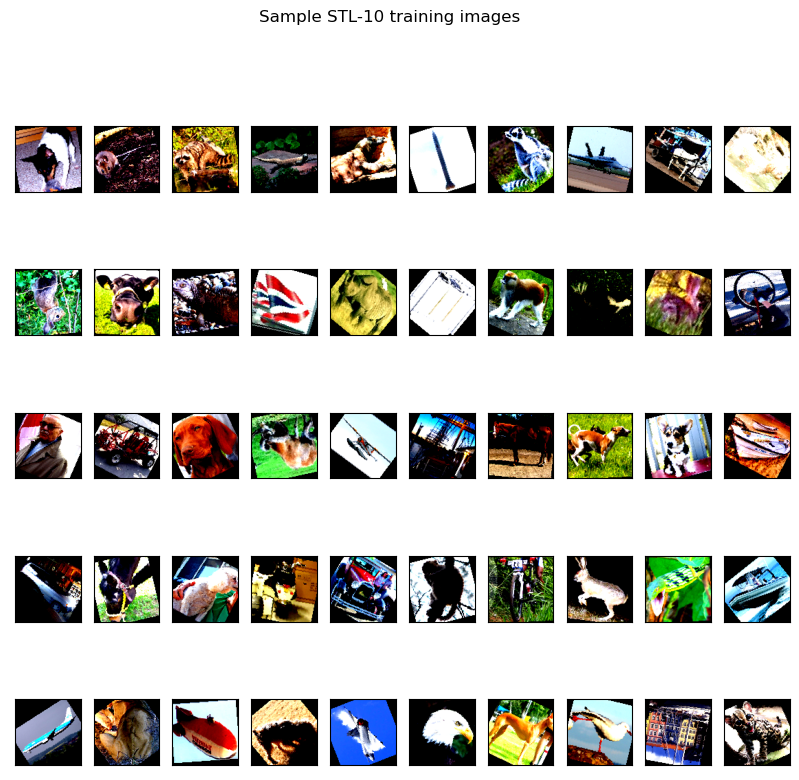

In [15]:
# Visualize 50 images from training set-
plt.figure(figsize = (10, 9))

for i in range(50):
    plt.subplot(5, 10, i + 1)
    plt.imshow(images[i])
    # get current axes-
    ax = plt.gca()

    # hide x-axis-
    ax.get_xaxis().set_visible(False)

    # hide y-axis-
    ax.get_yaxis().set_visible(False)
    
plt.suptitle("Sample STL-10 training images")
plt.show()

In [ ]:
del images, labels, lab, cnt

### Change the first conv layer:

Use the hyper-parameters: kernel_size=3, stride=1 and padding=1 instead of the original ResNet-50 hyper-parameters. This keeps the original input size for quite a while in forward propagation. In my experiments, doing this is leads to a higher validation accuracy and is probably more efficient for small input dataset(s) such as CIFAR-10.

[PyTorch discussion](https://discuss.pytorch.org/t/resnet50-torchvision-implementation-gives-low-accuracy-on-cifar-10/82046/3)

In [10]:
def get_resnet18_stl(num_classes = 10):
    # Load pre-trained ResNet-50 model-
    model_ft = torchvision.models.resnet18(weights = torchvision.models.resnet.ResNet18_Weights.DEFAULT)
    # Precise path: 'C:\Users\arjun\.cache\torch\hub\checkpoints\'
    
    # Compute number of features for defining last linear/dense layer-
    num_ftrs = model_ft.fc.in_features
    # print(f"number of input features = {num_ftrs}")
    # number of input features = 2048
    
    # Define last dense layer/output layer-
    model_ft.fc = nn.Linear(in_features = num_ftrs, out_features = num_classes)
    
    # Change first conv layer of ResNet-18:
    model_ft.conv1 = torch.nn.Conv2d(
        in_channels = 3, out_channels = 64,
        kernel_size = (3, 3), stride = (1, 1),
        padding = (1, 1), bias = False
    )
    
    return model_ft


In [11]:
model = get_resnet18_stl(num_classes = 10)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\arjun/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|█████████████████████████████████████████████████████████████████████████████| 44.7M/44.7M [00:07<00:00, 6.36MB/s]


In [ ]:
"""
for layer_name, params in model.named_parameters():
    print(f"{layer_name} has {params.shape} params")
"""
# A verbose output!

In [ ]:
# Sanity check-
# model_ft.conv1

In [ ]:
# Further sanity check-
# print(model)

In [12]:
# Save weights before fine-tuning-
# torch.save(model.state_dict(), "ResNet18__pretrained_weights.pth")

In [14]:
# Load weights from above-
model.load_state_dict(torch.load('ResNet18__pretrained_weights.pth'))

<All keys matched successfully>

### Train parameters of newly added layers

We need to freeze all the pre-trained network layers except for the newly added layers, viz., the first conv layer and the final dense layer. We need to set ```requires_grad = False``` to freeze the parameters so that the gradients are not computed in ```backward()```.

[Transfer Learning PyTorch Tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)

In [18]:
for param in model.parameters():
    param.requires_grad = False

In [19]:
# Set first conv and output layer to train-
model.conv1.weight.requires_grad = True
model.bn1.weight.requires_grad = True
model.bn1.bias.requires_grad = True

model.fc.weight.requires_grad = True
model.fc.bias.requires_grad = True

In [20]:
# Sanity check-
for layer_name, param in model.named_parameters():
    print(f"layer: {layer_name}, shape: {param.shape}, requires grad? {param.requires_grad}")

layer: conv1.weight, shape: torch.Size([64, 3, 3, 3]), requires grad? True
layer: bn1.weight, shape: torch.Size([64]), requires grad? True
layer: bn1.bias, shape: torch.Size([64]), requires grad? True
layer: layer1.0.conv1.weight, shape: torch.Size([64, 64, 3, 3]), requires grad? False
layer: layer1.0.bn1.weight, shape: torch.Size([64]), requires grad? False
layer: layer1.0.bn1.bias, shape: torch.Size([64]), requires grad? False
layer: layer1.0.conv2.weight, shape: torch.Size([64, 64, 3, 3]), requires grad? False
layer: layer1.0.bn2.weight, shape: torch.Size([64]), requires grad? False
layer: layer1.0.bn2.bias, shape: torch.Size([64]), requires grad? False
layer: layer1.1.conv1.weight, shape: torch.Size([64, 64, 3, 3]), requires grad? False
layer: layer1.1.bn1.weight, shape: torch.Size([64]), requires grad? False
layer: layer1.1.bn1.bias, shape: torch.Size([64]), requires grad? False
layer: layer1.1.conv2.weight, shape: torch.Size([64, 64, 3, 3]), requires grad? False
layer: layer1.1.b

In [21]:
# Define number of fine-tuning epochs-
num_epochs = 25

In [22]:
# Place model on GPU-
model = model.to(device)

In [23]:
# Define cost function-
cost_fn = nn.CrossEntropyLoss()

# Learning rate - Observe that all parameters are being optimized-
optimizer = torch.optim.SGD(model.parameters(), lr = 1e-3, momentum = 0.9)

#### MultiStepLR PyTorch

```
torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones, gamma=0.1, last_epoch=- 1, verbose=False)
```

Decays the learning rate of each parameter group by _gamma_ once the number of epoch reaches one of the milestones. Notice that such decay can happen simultaneously with other changes to the learning rate from outside this scheduler. When last_epoch=-1, sets initial lr as lr.

Parameters:

- optimizer (Optimizer) – Wrapped optimizer.
- milestones (list) – List of epoch indices. Must be increasing.
- gamma (float) – Multiplicative factor of learning rate decay. Default: 0.1.
- last_epoch (int) – The index of last epoch. Default: -1.
- verbose (bool) – If True, prints a message to stdout for each update. Default: False.

Example:

```
# Assuming optimizer uses lr = 0.05 for all groups
# lr = 0.05     if epoch < 30
# lr = 0.005    if 30 <= epoch < 80
# lr = 0.0005   if epoch >= 80
scheduler = MultiStepLR(optimizer, milestones=[30,80], gamma=0.1)
```

[MultiStepLR](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.MultiStepLR.html). You might aso consider [StepLR](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.StepLR.html) scheduler.

In [ ]:
# Learning rate scheduler - Decay LR by a factor of 0.1 every 10 epochs-
# exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 10, gamma = 0.1)

In [24]:
# Decay lr at 9th and 20th epochs by a factor of 10-
scheduler = torch.optim.lr_scheduler.MultiStepLR(
    optimizer = optimizer, milestones = [9, 20],
    gamma = 0.1
)

In [25]:
def train_one_step(model, train_loader, train_dataset):
    running_loss = 0.0
    running_corrects = 0.0
    
    model.to(device)
    model.train()
    
    with tqdm(train_loader, unit = 'batch') as tepoch:
        for images, labels in tepoch:
            tepoch.set_description(f"Training: ")
            
            images = images.to(device)
            labels = labels.to(device)
            
            # Get model predictions-
            outputs = model(images)
            
            # Compute loss-
            J = cost_fn(outputs, labels)
            
            # Empty accumulated gradients-
            optimizer.zero_grad()
            
            # Perform backprop-
            J.backward()
            
            # Update parameters-
            optimizer.step()
            
            # Compute model's performance statistics-
            running_loss += J.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            running_corrects += torch.sum(predicted == labels.data)
            
            tepoch.set_postfix(
                loss = running_loss / len(train_dataset),
                accuracy = (running_corrects.double().cpu().numpy() / len(train_dataset)) * 100
            )
            
    
    train_loss = running_loss / len(train_dataset)
    train_acc = (running_corrects.double() / len(train_dataset)) * 100
    
    return train_loss, train_acc.detach().cpu().item()


In [26]:
def test_one_step(model, test_loader, test_dataset):
    total = 0.0
    correct = 0.0
    running_loss_val = 0.0
    
    model.to(device)
    model.eval()

    with torch.no_grad():
        with tqdm(test_loader, unit = 'batch') as tepoch:
            for images, labels in tepoch:
                tepoch.set_description(f"Validation: ")
                
                images = images.to(device)
                labels = labels.to(device)
                
                # Predict using trained model-
                outputs = model(images)
                _, y_pred = torch.max(outputs, 1)
                
                # Compute validation loss-
                J_val = cost_fn(outputs, labels)
                
                running_loss_val += J_val.item() * labels.size(0)
    
                # Total number of labels-
                total += labels.size(0)

                # Total number of correct predictions-
                correct += (y_pred == labels).sum()
                
                tepoch.set_postfix(
                    val_loss = running_loss_val / len(test_dataset),
                    val_acc = 100 * (correct.cpu().numpy() / total)
                )
            
        
    # return (running_loss_val, correct, total)
    val_loss = running_loss_val / len(test_dataset)
    val_acc = (correct / total) * 100

    return val_loss, val_acc.detach().cpu().item()


In [27]:
# Python3 dict to contain model training metrics-
train_history = {}

# To save 'best' parameters-
best_val_acc = 20

In [28]:
for epoch in range(1, num_epochs + 1):
    
    # One epoch of training-
    train_loss, train_acc = train_one_step(
        model = model, train_loader = train_loader,
        train_dataset = train_dataset
    )
    
    # Get validation metrics after 1 epoch of training-
    val_loss, val_acc = test_one_step(
        model = model, test_loader = test_loader,
        test_dataset = test_dataset
    )
    
    scheduler.step()
    
    current_lr = optimizer.param_groups[0]["lr"]
    
    print(f"Epoch: {epoch}; loss = {train_loss:.4f}, acc = {train_acc:.2f}%",
          f" val loss = {val_loss:.4f}, val acc = {val_acc:.2f}% & LR = {current_lr:.5f}"
         )
    
    # Save training metrics to Python3 dict-
    train_history[epoch] = {
        'train_loss': train_loss, 'val_loss': val_loss,
        'train_acc': train_acc, 'val_acc': val_acc,
        'lr': current_lr
    }
    
    # Save model with best validation accuracy-
    if (val_acc > best_val_acc):
        best_val_acc = val_acc
        print(f"Saving model with highest val_acc = {val_acc:.2f}%\n")
        torch.save(model.state_dict(), "ResNet18_STL10_best_val_acc.pth")
        

Validation: : 100%|████████████████████████████████████| 63/63 [00:05<00:00, 11.77batch/s, val_acc=20.4, val_loss=2.17]


Epoch: 1; loss = 2.3296, acc = 13.26%  val loss = 2.1679, val acc = 20.36% & LR = 0.00100
Saving model with highest val_acc = 20.36%



Validation: : 100%|████████████████████████████████████| 63/63 [00:05<00:00, 11.76batch/s, val_acc=29.5, val_loss=1.95]


Epoch: 2; loss = 2.0745, acc = 25.12%  val loss = 1.9460, val acc = 29.53% & LR = 0.00100
Saving model with highest val_acc = 29.53%



Validation: : 100%|████████████████████████████████████| 63/63 [00:05<00:00, 11.69batch/s, val_acc=36.1, val_loss=1.79]


Epoch: 3; loss = 1.8892, acc = 34.00%  val loss = 1.7931, val acc = 36.14% & LR = 0.00100
Saving model with highest val_acc = 36.14%



Validation: : 100%|████████████████████████████████████| 63/63 [00:05<00:00, 11.71batch/s, val_acc=40.5, val_loss=1.68]


Epoch: 4; loss = 1.7730, acc = 37.48%  val loss = 1.6819, val acc = 40.53% & LR = 0.00100
Saving model with highest val_acc = 40.53%



Validation: : 100%|█████████████████████████████████████| 63/63 [00:05<00:00, 11.74batch/s, val_acc=43.9, val_loss=1.6]


Epoch: 5; loss = 1.6803, acc = 41.50%  val loss = 1.5964, val acc = 43.86% & LR = 0.00100
Saving model with highest val_acc = 43.86%



Validation: : 100%|████████████████████████████████████| 63/63 [00:05<00:00, 11.71batch/s, val_acc=44.9, val_loss=1.56]


Epoch: 6; loss = 1.6139, acc = 44.26%  val loss = 1.5583, val acc = 44.88% & LR = 0.00100
Saving model with highest val_acc = 44.88%



Validation: : 100%|████████████████████████████████████| 63/63 [00:05<00:00, 11.71batch/s, val_acc=48.3, val_loss=1.47]


Epoch: 7; loss = 1.5623, acc = 45.92%  val loss = 1.4734, val acc = 48.30% & LR = 0.00100
Saving model with highest val_acc = 48.30%



Validation: : 100%|████████████████████████████████████| 63/63 [00:05<00:00, 11.70batch/s, val_acc=49.3, val_loss=1.43]


Epoch: 8; loss = 1.5175, acc = 46.96%  val loss = 1.4349, val acc = 49.26% & LR = 0.00100
Saving model with highest val_acc = 49.26%



Validation: : 100%|████████████████████████████████████| 63/63 [00:05<00:00, 11.71batch/s, val_acc=50.3, val_loss=1.41]


Epoch: 9; loss = 1.4687, acc = 48.42%  val loss = 1.4059, val acc = 50.34% & LR = 0.00010
Saving model with highest val_acc = 50.34%



Validation: : 100%|████████████████████████████████████| 63/63 [00:05<00:00, 11.72batch/s, val_acc=51.5, val_loss=1.39]


Epoch: 10; loss = 1.4391, acc = 50.08%  val loss = 1.3915, val acc = 51.50% & LR = 0.00010
Saving model with highest val_acc = 51.50%



Validation: : 100%|████████████████████████████████████| 63/63 [00:05<00:00, 11.74batch/s, val_acc=52.3, val_loss=1.37]


Epoch: 11; loss = 1.4325, acc = 50.94%  val loss = 1.3743, val acc = 52.30% & LR = 0.00010
Saving model with highest val_acc = 52.30%



Validation: : 100%|████████████████████████████████████| 63/63 [00:05<00:00, 11.72batch/s, val_acc=52.1, val_loss=1.38]


Epoch: 12; loss = 1.4317, acc = 50.54%  val loss = 1.3802, val acc = 52.12% & LR = 0.00010


Validation: : 100%|████████████████████████████████████| 63/63 [00:05<00:00, 11.72batch/s, val_acc=52.5, val_loss=1.37]


Epoch: 13; loss = 1.4301, acc = 50.12%  val loss = 1.3726, val acc = 52.50% & LR = 0.00010
Saving model with highest val_acc = 52.50%



Validation: : 100%|████████████████████████████████████| 63/63 [00:05<00:00, 11.75batch/s, val_acc=52.1, val_loss=1.37]


Epoch: 14; loss = 1.4340, acc = 51.08%  val loss = 1.3669, val acc = 52.09% & LR = 0.00010


Validation: : 100%|████████████████████████████████████| 63/63 [00:05<00:00, 11.75batch/s, val_acc=52.5, val_loss=1.36]


Epoch: 15; loss = 1.4252, acc = 49.96%  val loss = 1.3640, val acc = 52.48% & LR = 0.00010


Validation: : 100%|████████████████████████████████████| 63/63 [00:05<00:00, 11.71batch/s, val_acc=52.9, val_loss=1.36]


Epoch: 16; loss = 1.4129, acc = 49.80%  val loss = 1.3605, val acc = 52.93% & LR = 0.00010
Saving model with highest val_acc = 52.93%



Validation: : 100%|████████████████████████████████████| 63/63 [00:05<00:00, 11.68batch/s, val_acc=52.6, val_loss=1.36]


Epoch: 17; loss = 1.4032, acc = 51.84%  val loss = 1.3574, val acc = 52.61% & LR = 0.00010


Validation: : 100%|████████████████████████████████████| 63/63 [00:05<00:00, 11.72batch/s, val_acc=52.8, val_loss=1.36]


Epoch: 18; loss = 1.4062, acc = 51.44%  val loss = 1.3553, val acc = 52.79% & LR = 0.00010


Validation: : 100%|██████████████████████████████████████| 63/63 [00:05<00:00, 11.73batch/s, val_acc=53, val_loss=1.35]


Epoch: 19; loss = 1.4085, acc = 51.24%  val loss = 1.3522, val acc = 52.98% & LR = 0.00010
Saving model with highest val_acc = 52.98%



Validation: : 100%|████████████████████████████████████| 63/63 [00:05<00:00, 11.72batch/s, val_acc=53.1, val_loss=1.34]


Epoch: 20; loss = 1.4057, acc = 50.18%  val loss = 1.3438, val acc = 53.06% & LR = 0.00001
Saving model with highest val_acc = 53.06%



Validation: : 100%|████████████████████████████████████| 63/63 [00:05<00:00, 11.73batch/s, val_acc=53.5, val_loss=1.34]


Epoch: 21; loss = 1.3974, acc = 51.52%  val loss = 1.3429, val acc = 53.49% & LR = 0.00001
Saving model with highest val_acc = 53.49%



Validation: : 100%|████████████████████████████████████| 63/63 [00:05<00:00, 11.70batch/s, val_acc=53.1, val_loss=1.34]


Epoch: 22; loss = 1.3966, acc = 51.78%  val loss = 1.3428, val acc = 53.15% & LR = 0.00001


Validation: : 100%|████████████████████████████████████| 63/63 [00:05<00:00, 11.70batch/s, val_acc=53.1, val_loss=1.34]


Epoch: 23; loss = 1.4028, acc = 51.50%  val loss = 1.3449, val acc = 53.11% & LR = 0.00001


Validation: : 100%|██████████████████████████████████████| 63/63 [00:05<00:00, 11.71batch/s, val_acc=53, val_loss=1.35]


Epoch: 24; loss = 1.4048, acc = 51.66%  val loss = 1.3480, val acc = 53.03% & LR = 0.00001


Validation: : 100%|████████████████████████████████████| 63/63 [00:05<00:00, 11.70batch/s, val_acc=53.5, val_loss=1.34]


Epoch: 25; loss = 1.3991, acc = 50.88%  val loss = 1.3402, val acc = 53.53% & LR = 0.00001
Saving model with highest val_acc = 53.53%



### Unfreeze all layers and train with lr of last epoch

In [29]:
for param in model.parameters():
    param.requires_grad = True

In [30]:
# Sanity check-
for layer_name, param in model.named_parameters():
    print(f"layer: {layer_name}, shape: {param.shape}, requires grad? {param.requires_grad}")

layer: conv1.weight, shape: torch.Size([64, 3, 3, 3]), requires grad? True
layer: bn1.weight, shape: torch.Size([64]), requires grad? True
layer: bn1.bias, shape: torch.Size([64]), requires grad? True
layer: layer1.0.conv1.weight, shape: torch.Size([64, 64, 3, 3]), requires grad? True
layer: layer1.0.bn1.weight, shape: torch.Size([64]), requires grad? True
layer: layer1.0.bn1.bias, shape: torch.Size([64]), requires grad? True
layer: layer1.0.conv2.weight, shape: torch.Size([64, 64, 3, 3]), requires grad? True
layer: layer1.0.bn2.weight, shape: torch.Size([64]), requires grad? True
layer: layer1.0.bn2.bias, shape: torch.Size([64]), requires grad? True
layer: layer1.1.conv1.weight, shape: torch.Size([64, 64, 3, 3]), requires grad? True
layer: layer1.1.bn1.weight, shape: torch.Size([64]), requires grad? True
layer: layer1.1.bn1.bias, shape: torch.Size([64]), requires grad? True
layer: layer1.1.conv2.weight, shape: torch.Size([64, 64, 3, 3]), requires grad? True
layer: layer1.1.bn2.weight,

In [36]:
optimizer = torch.optim.SGD(model.parameters(), lr = 1e-5, momentum = 0.9)

In [37]:
# Decay lr at 20th and 30th epochs by a factor of 10-
scheduler = torch.optim.lr_scheduler.MultiStepLR(
    optimizer = optimizer, milestones = [20, 30],
    gamma = 0.1
)

In [43]:
# Train for 50 more epochs-
num_epochs = 50

In [44]:
for epoch in range(26, 25 + num_epochs + 1):
    
    # One epoch of training-
    train_loss, train_acc = train_one_step(
        model = model, train_loader = train_loader,
        train_dataset = train_dataset
    )
    
    # Get validation metrics after 1 epoch of training-
    val_loss, val_acc = test_one_step(
        model = model, test_loader = test_loader,
        test_dataset = test_dataset
    )
    
    scheduler.step()
    
    current_lr = optimizer.param_groups[0]["lr"]
    
    print(f"Epoch: {epoch}; loss = {train_loss:.4f}, acc = {train_acc:.2f}%",
          f" val loss = {val_loss:.4f}, val acc = {val_acc:.2f}% & LR = {current_lr:.8f}"
         )
    
    # Save training metrics to Python3 dict-
    train_history[epoch] = {
        'train_loss': train_loss, 'val_loss': val_loss,
        'train_acc': train_acc, 'val_acc': val_acc,
        'lr': current_lr
    }
    
    # Save model with best validation accuracy-
    if (val_acc > best_val_acc):
        best_val_acc = val_acc
        print(f"Saving model with highest val_acc = {val_acc:.2f}%\n")
        torch.save(model.state_dict(), "ResNet18_STL10_best_val_acc.pth")
        

Validation: : 100%|████████████████████████████████████| 63/63 [00:05<00:00, 11.76batch/s, val_acc=52.9, val_loss=1.35]


Epoch: 26; loss = 1.3971, acc = 50.88%  val loss = 1.3460, val acc = 52.95% & LR = 0.00001000


Validation: : 100%|████████████████████████████████████| 63/63 [00:05<00:00, 11.69batch/s, val_acc=53.8, val_loss=1.33]


Epoch: 27; loss = 1.3927, acc = 52.14%  val loss = 1.3341, val acc = 53.76% & LR = 0.00001000
Saving model with highest val_acc = 53.76%



Validation: : 100%|████████████████████████████████████| 63/63 [00:05<00:00, 11.68batch/s, val_acc=53.6, val_loss=1.34]


Epoch: 28; loss = 1.3841, acc = 51.48%  val loss = 1.3371, val acc = 53.60% & LR = 0.00001000


Validation: : 100%|████████████████████████████████████| 63/63 [00:05<00:00, 11.73batch/s, val_acc=53.7, val_loss=1.33]


Epoch: 29; loss = 1.3755, acc = 52.00%  val loss = 1.3269, val acc = 53.68% & LR = 0.00001000


Validation: : 100%|████████████████████████████████████| 63/63 [00:05<00:00, 11.70batch/s, val_acc=53.3, val_loss=1.33]


Epoch: 30; loss = 1.3825, acc = 51.90%  val loss = 1.3296, val acc = 53.31% & LR = 0.00001000


Validation: : 100%|████████████████████████████████████| 63/63 [00:05<00:00, 11.72batch/s, val_acc=53.9, val_loss=1.31]


Epoch: 31; loss = 1.3797, acc = 51.66%  val loss = 1.3149, val acc = 53.93% & LR = 0.00001000
Saving model with highest val_acc = 53.93%



Validation: : 100%|██████████████████████████████████████| 63/63 [00:05<00:00, 11.73batch/s, val_acc=54, val_loss=1.32]


Epoch: 32; loss = 1.3717, acc = 51.42%  val loss = 1.3160, val acc = 53.98% & LR = 0.00001000
Saving model with highest val_acc = 53.98%



Validation: : 100%|████████████████████████████████████| 63/63 [00:05<00:00, 11.74batch/s, val_acc=54.2, val_loss=1.31]


Epoch: 33; loss = 1.3609, acc = 52.68%  val loss = 1.3092, val acc = 54.18% & LR = 0.00001000
Saving model with highest val_acc = 54.18%



Validation: : 100%|████████████████████████████████████| 63/63 [00:05<00:00, 11.71batch/s, val_acc=54.1, val_loss=1.31]


Epoch: 34; loss = 1.3635, acc = 52.08%  val loss = 1.3109, val acc = 54.09% & LR = 0.00001000


Validation: : 100%|█████████████████████████████████████| 63/63 [00:05<00:00, 11.73batch/s, val_acc=54.4, val_loss=1.3]


Epoch: 35; loss = 1.3608, acc = 53.56%  val loss = 1.2989, val acc = 54.35% & LR = 0.00001000
Saving model with highest val_acc = 54.35%



Validation: : 100%|█████████████████████████████████████| 63/63 [00:05<00:00, 11.69batch/s, val_acc=54.3, val_loss=1.3]


Epoch: 36; loss = 1.3467, acc = 53.06%  val loss = 1.3012, val acc = 54.29% & LR = 0.00001000


Validation: : 100%|█████████████████████████████████████| 63/63 [00:05<00:00, 11.71batch/s, val_acc=54.2, val_loss=1.3]


Epoch: 37; loss = 1.3546, acc = 52.60%  val loss = 1.3016, val acc = 54.18% & LR = 0.00001000


Validation: : 100%|████████████████████████████████████| 63/63 [00:05<00:00, 11.67batch/s, val_acc=54.4, val_loss=1.29]


Epoch: 38; loss = 1.3435, acc = 53.56%  val loss = 1.2933, val acc = 54.41% & LR = 0.00001000
Saving model with highest val_acc = 54.41%



Validation: : 100%|████████████████████████████████████| 63/63 [00:05<00:00, 11.57batch/s, val_acc=54.7, val_loss=1.29]


Epoch: 39; loss = 1.3411, acc = 53.22%  val loss = 1.2868, val acc = 54.73% & LR = 0.00001000
Saving model with highest val_acc = 54.73%



Validation: : 100%|████████████████████████████████████| 63/63 [00:05<00:00, 11.69batch/s, val_acc=54.5, val_loss=1.29]


Epoch: 40; loss = 1.3436, acc = 53.22%  val loss = 1.2905, val acc = 54.48% & LR = 0.00001000


Validation: : 100%|██████████████████████████████████████| 63/63 [00:05<00:00, 11.70batch/s, val_acc=55, val_loss=1.28]


Epoch: 41; loss = 1.3405, acc = 53.88%  val loss = 1.2847, val acc = 54.99% & LR = 0.00001000
Saving model with highest val_acc = 54.99%



Validation: : 100%|████████████████████████████████████| 63/63 [00:05<00:00, 11.66batch/s, val_acc=54.9, val_loss=1.28]


Epoch: 42; loss = 1.3359, acc = 53.44%  val loss = 1.2836, val acc = 54.88% & LR = 0.00001000


Validation: : 100%|████████████████████████████████████| 63/63 [00:05<00:00, 11.68batch/s, val_acc=54.9, val_loss=1.28]


Epoch: 43; loss = 1.3364, acc = 53.46%  val loss = 1.2810, val acc = 54.91% & LR = 0.00001000


Validation: : 100%|████████████████████████████████████| 63/63 [00:05<00:00, 11.72batch/s, val_acc=55.4, val_loss=1.27]


Epoch: 44; loss = 1.3267, acc = 54.12%  val loss = 1.2710, val acc = 55.40% & LR = 0.00001000
Saving model with highest val_acc = 55.40%



Validation: : 100%|████████████████████████████████████| 63/63 [00:05<00:00, 11.71batch/s, val_acc=55.3, val_loss=1.27]


Epoch: 45; loss = 1.3168, acc = 54.06%  val loss = 1.2682, val acc = 55.26% & LR = 0.00000100


Validation: : 100%|████████████████████████████████████| 63/63 [00:05<00:00, 11.74batch/s, val_acc=55.3, val_loss=1.27]


Epoch: 46; loss = 1.3311, acc = 54.56%  val loss = 1.2657, val acc = 55.31% & LR = 0.00000100


Validation: : 100%|████████████████████████████████████| 63/63 [00:05<00:00, 11.75batch/s, val_acc=54.9, val_loss=1.27]


Epoch: 47; loss = 1.3157, acc = 54.46%  val loss = 1.2719, val acc = 54.91% & LR = 0.00000100


Validation: : 100%|████████████████████████████████████| 63/63 [00:05<00:00, 11.71batch/s, val_acc=55.2, val_loss=1.27]


Epoch: 48; loss = 1.3224, acc = 54.30%  val loss = 1.2672, val acc = 55.16% & LR = 0.00000100


Validation: : 100%|██████████████████████████████████████| 63/63 [00:05<00:00, 11.74batch/s, val_acc=55, val_loss=1.27]


Epoch: 49; loss = 1.3160, acc = 54.12%  val loss = 1.2701, val acc = 55.03% & LR = 0.00000100


Validation: : 100%|████████████████████████████████████| 63/63 [00:05<00:00, 11.73batch/s, val_acc=55.3, val_loss=1.27]


Epoch: 50; loss = 1.3208, acc = 53.66%  val loss = 1.2678, val acc = 55.28% & LR = 0.00000100


Validation: : 100%|████████████████████████████████████| 63/63 [00:05<00:00, 11.70batch/s, val_acc=55.4, val_loss=1.27]


Epoch: 51; loss = 1.3090, acc = 54.96%  val loss = 1.2743, val acc = 55.40% & LR = 0.00000100


Validation: : 100%|████████████████████████████████████| 63/63 [00:05<00:00, 11.73batch/s, val_acc=55.4, val_loss=1.27]


Epoch: 52; loss = 1.3181, acc = 53.88%  val loss = 1.2666, val acc = 55.40% & LR = 0.00000100


Validation: : 100%|████████████████████████████████████| 63/63 [00:05<00:00, 11.68batch/s, val_acc=55.2, val_loss=1.27]


Epoch: 53; loss = 1.3239, acc = 53.54%  val loss = 1.2689, val acc = 55.19% & LR = 0.00000100


Validation: : 100%|████████████████████████████████████| 63/63 [00:05<00:00, 11.72batch/s, val_acc=55.3, val_loss=1.27]


Epoch: 54; loss = 1.3135, acc = 54.52%  val loss = 1.2703, val acc = 55.26% & LR = 0.00000100


Validation: : 100%|████████████████████████████████████| 63/63 [00:05<00:00, 11.71batch/s, val_acc=55.1, val_loss=1.27]


Epoch: 55; loss = 1.3124, acc = 54.48%  val loss = 1.2692, val acc = 55.15% & LR = 0.00000010


Validation: : 100%|████████████████████████████████████| 63/63 [00:05<00:00, 11.71batch/s, val_acc=55.1, val_loss=1.27]


Epoch: 56; loss = 1.3200, acc = 53.68%  val loss = 1.2699, val acc = 55.11% & LR = 0.00000010


Validation: : 100%|████████████████████████████████████| 63/63 [00:05<00:00, 11.70batch/s, val_acc=55.2, val_loss=1.27]


Epoch: 57; loss = 1.3187, acc = 54.50%  val loss = 1.2675, val acc = 55.25% & LR = 0.00000010


Validation: : 100%|████████████████████████████████████| 63/63 [00:05<00:00, 11.74batch/s, val_acc=55.5, val_loss=1.27]


Epoch: 58; loss = 1.3044, acc = 55.12%  val loss = 1.2678, val acc = 55.45% & LR = 0.00000010
Saving model with highest val_acc = 55.45%



Validation: : 100%|████████████████████████████████████| 63/63 [00:05<00:00, 11.70batch/s, val_acc=55.1, val_loss=1.27]


Epoch: 59; loss = 1.3103, acc = 53.84%  val loss = 1.2691, val acc = 55.08% & LR = 0.00000010


Validation: : 100%|████████████████████████████████████| 63/63 [00:05<00:00, 11.70batch/s, val_acc=55.2, val_loss=1.27]


Epoch: 60; loss = 1.3208, acc = 53.74%  val loss = 1.2657, val acc = 55.21% & LR = 0.00000010


Validation: : 100%|████████████████████████████████████| 63/63 [00:05<00:00, 11.73batch/s, val_acc=55.2, val_loss=1.27]


Epoch: 61; loss = 1.3220, acc = 53.80%  val loss = 1.2695, val acc = 55.17% & LR = 0.00000010


Validation: : 100%|████████████████████████████████████| 63/63 [00:05<00:00, 11.71batch/s, val_acc=55.4, val_loss=1.27]


Epoch: 62; loss = 1.3188, acc = 54.00%  val loss = 1.2694, val acc = 55.39% & LR = 0.00000010


Validation: : 100%|████████████████████████████████████| 63/63 [00:05<00:00, 11.70batch/s, val_acc=55.6, val_loss=1.27]


Epoch: 63; loss = 1.3166, acc = 54.08%  val loss = 1.2653, val acc = 55.58% & LR = 0.00000010
Saving model with highest val_acc = 55.58%



Validation: : 100%|████████████████████████████████████| 63/63 [00:05<00:00, 11.73batch/s, val_acc=55.2, val_loss=1.27]


Epoch: 64; loss = 1.3180, acc = 54.36%  val loss = 1.2696, val acc = 55.16% & LR = 0.00000010


Validation: : 100%|████████████████████████████████████| 63/63 [00:05<00:00, 11.70batch/s, val_acc=55.1, val_loss=1.27]


Epoch: 65; loss = 1.3213, acc = 54.28%  val loss = 1.2746, val acc = 55.06% & LR = 0.00000010


Validation: : 100%|████████████████████████████████████| 63/63 [00:05<00:00, 11.71batch/s, val_acc=55.2, val_loss=1.27]


Epoch: 66; loss = 1.3203, acc = 53.98%  val loss = 1.2668, val acc = 55.23% & LR = 0.00000010


Validation: : 100%|████████████████████████████████████| 63/63 [00:05<00:00, 11.69batch/s, val_acc=55.2, val_loss=1.27]


Epoch: 67; loss = 1.3253, acc = 53.56%  val loss = 1.2726, val acc = 55.16% & LR = 0.00000010


Validation: : 100%|████████████████████████████████████| 63/63 [00:05<00:00, 11.71batch/s, val_acc=55.3, val_loss=1.27]


Epoch: 68; loss = 1.3135, acc = 54.40%  val loss = 1.2699, val acc = 55.33% & LR = 0.00000010


Validation: : 100%|████████████████████████████████████| 63/63 [00:05<00:00, 11.71batch/s, val_acc=55.6, val_loss=1.26]


Epoch: 69; loss = 1.3214, acc = 53.44%  val loss = 1.2638, val acc = 55.58% & LR = 0.00000010


Validation: : 100%|████████████████████████████████████| 63/63 [00:05<00:00, 11.72batch/s, val_acc=55.6, val_loss=1.26]


Epoch: 70; loss = 1.3106, acc = 54.70%  val loss = 1.2619, val acc = 55.59% & LR = 0.00000010
Saving model with highest val_acc = 55.59%



Validation: : 100%|████████████████████████████████████| 63/63 [00:05<00:00, 11.71batch/s, val_acc=55.2, val_loss=1.27]


Epoch: 71; loss = 1.3190, acc = 54.18%  val loss = 1.2662, val acc = 55.21% & LR = 0.00000010


Validation: : 100%|████████████████████████████████████| 63/63 [00:05<00:00, 11.71batch/s, val_acc=55.2, val_loss=1.27]


Epoch: 72; loss = 1.3209, acc = 54.14%  val loss = 1.2682, val acc = 55.24% & LR = 0.00000010


Validation: : 100%|████████████████████████████████████| 63/63 [00:05<00:00, 11.71batch/s, val_acc=55.1, val_loss=1.27]


Epoch: 73; loss = 1.3187, acc = 54.36%  val loss = 1.2716, val acc = 55.13% & LR = 0.00000010


Validation: : 100%|████████████████████████████████████| 63/63 [00:05<00:00, 11.73batch/s, val_acc=54.9, val_loss=1.28]


Epoch: 74; loss = 1.3180, acc = 54.50%  val loss = 1.2779, val acc = 54.89% & LR = 0.00000010


Validation: : 100%|████████████████████████████████████| 63/63 [00:05<00:00, 11.71batch/s, val_acc=55.4, val_loss=1.27]

Epoch: 75; loss = 1.3218, acc = 54.28%  val loss = 1.2674, val acc = 55.36% & LR = 0.00000010


In [46]:
# Save training metrics as pickled object-
with open("ResNet18_STL10_training_history.pkl", "wb") as file:
    pickle.dump(train_history, file)

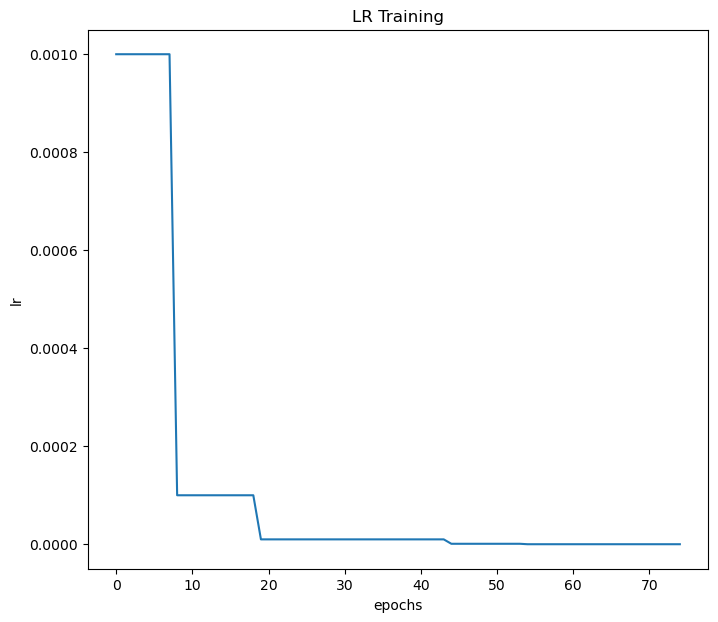

In [47]:
plt.figure(figsize = (8, 7))
plt.plot([train_history[e]['lr'] for e in train_history.keys()])
plt.xlabel("epochs")
plt.ylabel("lr")
plt.title("LR Training")
plt.show()

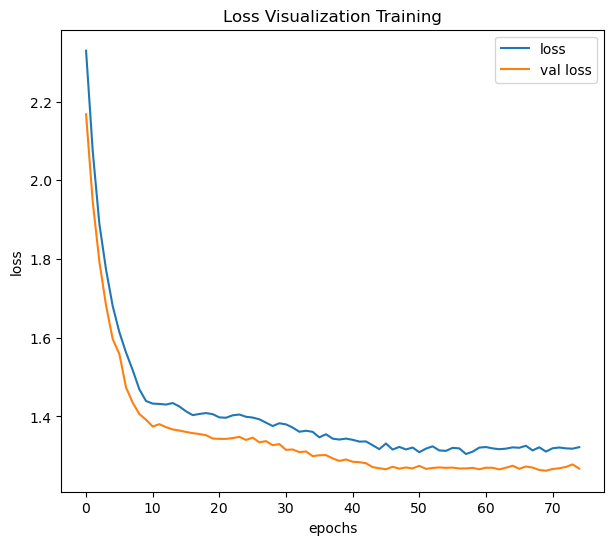

In [48]:
plt.figure(figsize = (7, 6))
plt.plot([train_history[e]['train_loss'] for e in train_history.keys()], label = 'loss')
plt.plot([train_history[e]['val_loss'] for e in train_history.keys()], label = 'val loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("Loss Visualization Training")
plt.legend(loc = 'best')
plt.show()

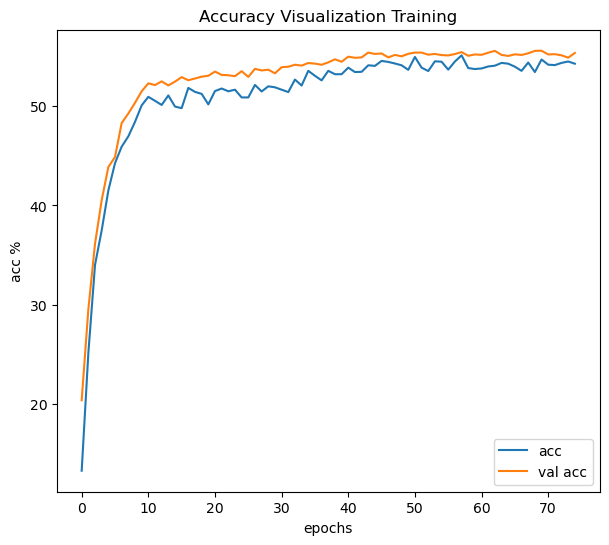

In [49]:
plt.figure(figsize = (7, 6))
plt.plot([train_history[e]['train_acc'] for e in train_history.keys()], label = 'acc')
plt.plot([train_history[e]['val_acc'] for e in train_history.keys()], label = 'val acc')
plt.xlabel("epochs")
plt.ylabel("acc %")
plt.title("Accuracy Visualization Training")
plt.legend(loc = 'best')
plt.show()